## 十四款常规机器学习建模

参考案例一：[module-sklearn.ensemble](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)

参考案例二：[ensemble-plot-feature-transformation](http://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py)


练习步骤为：

- 1、随机准备数据make_classification
- 2、两套模型的训练与基本信息准备
- 3、观察14套模型的准确率与召回率
- 4、刻画14套模型的calibration plots校准曲线
- 5、14套模型的重要性输出
- 6、14套模型的ROC值计算与plot
- 7、加权模型融合数据准备
- 8、基准优化策略：14套模型融合——平均
- 9、加权平均优化策略：14套模型融合——加权平均优化


In [1]:
# 函数加载


import numpy as np
import sklearn.metrics as metrics
from scipy.optimize import minimize
from sklearn.metrics import log_loss
from sklearn import metrics

def MinimiseOptimize(preds,models_filenames,nb_classes,sample_N,testY,NUM_TESTS = 20):
    '''
    preds ,此时为cifar_100 (6,10000, 100)
    testY,类别列表，100分类，就是：[[1],[2],[3],...],(100,1)
    nb_classesf,分类数,100
    models_filenames模型名称,5
    NUM_TESTS , 迭代次数，默认为20次
    '''
    best_acc = 0.0
    best_weights = None
    # Parameters for optimization
    constraints = ({'type': 'eq', 'fun':lambda w: 1 - sum(w)})
    bounds = [(0, 1)] * len(preds)

    # Check for NUM_TESTS times
    for iteration in range(NUM_TESTS):  # NUM_TESTS,迭代次数为25
        # Random initialization of weights
        prediction_weights = np.random.random(len(models_filenames))

        # Minimise the loss 
        result = minimize(log_loss_func, prediction_weights, method='SLSQP', bounds=bounds, constraints=constraints)

        weights = result['x']
        weighted_predictions = np.zeros((sample_N, nb_classes), dtype='float32')

        # Calculate weighted predictions
        for weight, prediction in zip(weights, preds):
            weighted_predictions += weight * prediction

        yPred = np.argmax(weighted_predictions, axis=1)
        yTrue = testY

        # Calculate weight prediction accuracy
        accuracy = metrics.accuracy_score(yTrue, yPred) * 100
        recall = recall_score(yTrue, yPred)

        print('\n ------- Iteration : %d  - acc: %s  - rec:%s -------  '%((iteration + 1),accuracy,recall))
        print('    Best Ensemble Weights: \n',result['x'])
        
        # Save current best weights 
        if accuracy > best_acc:
            best_acc = accuracy
            best_weights = weights
    return best_acc,best_weights

# Create the loss metric 
def log_loss_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = np.zeros((sample_N, nb_classes), dtype='float32')

    for weight, prediction in zip(weights, preds):
        final_prediction += weight * prediction

    return log_loss(testY_cat, final_prediction)

# calculate accuracy/recall

def calculate_weighted_accuracy(prediction_weights):
    '''计算acc/recall 以及得到预测结果'''
    weighted_predictions = np.zeros((sample_N, nb_classes), dtype='float32')
    for weight, prediction in zip(prediction_weights, preds):
        weighted_predictions += weight * prediction
    yPred = np.argmax(weighted_predictions, axis=1)
    yTrue = testY
    accuracy = metrics.accuracy_score(yTrue, yPred) * 100
    recall = recall_score(yTrue, yPred)
    print("Accuracy : ", accuracy)
    print("Recall : ", recall)
    



## 1、随机准备数据make_classification

In [2]:
import numpy as np
np.random.seed(10)
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,accuracy_score,recall_score
from sklearn.pipeline import make_pipeline
from sklearn.calibration import calibration_curve
import copy
print(__doc__)
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

def yLabel(y_pred):
    y_pred_f = copy.copy(y_pred)
    y_pred_f[y_pred_f>=0.5] = 1
    y_pred_f[y_pred_f<0.5] = 0
    return y_pred_f

def acc_recall(y_test, y_pred_rf):
    return {'accuracy': accuracy_score(y_test, yLabel(y_pred_rf)), \
            'recall': recall_score(y_test, yLabel(y_pred_rf))}

# 数据制作
X, y = make_classification(n_samples=10000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 4000)  # 对半分
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.2,random_state = 4000)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Automatically created module for IPython interactive environment
(6400, 20) (2000, 20) (6400,) (2000,)


## 2.1 八款主流机器学习模型

参考 [classifier-comparison](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py)


In [3]:

h = .02  # step size in the mesh
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
# 去掉"Gaussian Process"，太耗时，是其他的300倍以上

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    #RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

predictEight = {}
for name, clf in zip(names, classifiers):
    predictEight[name] = {}
    predictEight[name]['prob_pos'],predictEight[name]['fpr_tpr'],predictEight[name]['acc_recall'] = [],[],[]
    predictEight[name]['importance'] = []
    print('\n --- Start Model : %s ----\n'%name)
    %time clf.fit(X_train, y_train)
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        %time prob_pos = clf.decision_function(X_test)
        # # The confidence score for a sample is the signed distance of that sample to the hyperplane.
    else:
        %time prob_pos= clf.predict_proba(X_test)[:, 1]
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        # 需要归一化
    predictEight[name]['prob_pos'] = prob_pos
    
    # 计算ROC、acc、recall
    predictEight[name]['fpr_tpr'] = roc_curve(y_test, prob_pos)[:2]
    predictEight[name]['acc_recall'] = acc_recall(y_test, prob_pos)  # 计算准确率与召回
    
    # 提取重要性信息
    if hasattr(clf, "coef_"):
        predictEight[name]['importance'] = clf.coef_
    elif hasattr(clf, "feature_importances_"):
        predictEight[name]['importance'] = clf.feature_importances_
    elif hasattr(clf, "sigma_"):
        predictEight[name]['importance'] = clf.sigma_
        # variance of each feature per class


 --- Start Model : Nearest Neighbors ----

Wall time: 50.9 ms
Wall time: 862 ms

 --- Start Model : Linear SVM ----

Wall time: 630 ms
Wall time: 78.9 ms

 --- Start Model : RBF SVM ----

Wall time: 4.46 s
Wall time: 568 ms

 --- Start Model : Decision Tree ----

Wall time: 80.3 ms
Wall time: 0 ns

 --- Start Model : Neural Net ----

Wall time: 4.72 s
Wall time: 7.98 ms

 --- Start Model : AdaBoost ----

Wall time: 1.25 s
Wall time: 30.9 ms

 --- Start Model : Naive Bayes ----

Wall time: 4.91 ms
Wall time: 2.55 ms

 --- Start Model : QDA ----

Wall time: 8.05 ms
Wall time: 997 µs


C:\Users\YZHENG\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## 2.2 组合模型延伸

参考官网[feature-transformation](http://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py)



In [4]:
n_estimator = 100

'''
model 0 : lm
logistic
'''
print('LM 开始计算...')
lm = LogisticRegression()
%time lm.fit(X_train, y_train)
y_pred_lm = lm.predict_proba(X_test)[:, 1]
fpr_lm, tpr_lm, _ = roc_curve(y_test, y_pred_lm)
lm_ar = acc_recall(y_test, y_pred_lm)  # 计算准确率与召回

'''
model 1 : rt + lm
无监督变换 + lg
'''
# Unsupervised transformation based on totally random trees
print('随机森林编码+LM 开始计算...')
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,
    random_state=0)
# 数据集的无监督变换到高维稀疏表示。

rt_lm = LogisticRegression()
pipeline = make_pipeline(rt, rt_lm)
%time pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
rt_lm_ar = acc_recall(y_test, y_pred_rt)  # 计算准确率与召回

'''
model 2 : RF / RF+LM
'''
print('\n 随机森林系列 开始计算... ')
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))  # rf.apply(X_train)-(1310, 100)     X_train-(1310, 20)
# 用100棵树的信息作为X，载入做LM模型
%time rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)
rf_lm_ar = acc_recall(y_test, y_pred_rf_lm)  # 计算准确率与召回

'''
model 2 : GRD / GRD + LM
'''
print('\n 梯度提升树系列 开始计算... ')
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression()
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
%time grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)
grd_lm_ar = acc_recall(y_test, y_pred_grd_lm)  # 计算准确率与召回

# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)
grd_ar = acc_recall(y_test, y_pred_grd)  # 计算准确率与召回

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
rf_ar = acc_recall(y_test, y_pred_rf)  # 计算准确率与召回

LM 开始计算...
Wall time: 12 ms
随机森林编码+LM 开始计算...


C:\Users\YZHENG\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Wall time: 771 ms

 随机森林系列 开始计算... 


C:\Users\YZHENG\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Wall time: 181 ms

 梯度提升树系列 开始计算... 
Wall time: 198 ms


C:\Users\YZHENG\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 3、观察14套模型的准确率与召回率

In [5]:
print('----- 第一套,8款常规机器学习模型 -----')
for x,y in predictEight.items():
    print('\n ----- The Model  : %s , -----\n '%(x)  )
    print(predictEight[x]['acc_recall'])

print('\n ----- 第二套,6款组合机器学习模型 -----\n ')
names = ['LM','LM + RT','LM + RF','GBT + LM','GBT','RF']
ar_list = [lm_ar,rt_lm_ar,rf_lm_ar,grd_lm_ar,grd_ar,rf_ar]
for x,y in zip(names,ar_list):
    print('\n --- %s 准确率与召回为: ---- \n '%x,y)

----- 第一套,8款常规机器学习模型 -----

 ----- The Model  : Nearest Neighbors , -----
 
{'accuracy': 0.8315, 'recall': 0.8446014127144299}

 ----- The Model  : Linear SVM , -----
 
{'accuracy': 0.891, 'recall': 0.8456104944500504}

 ----- The Model  : RBF SVM , -----
 
{'accuracy': 0.5045, 'recall': 0.0}

 ----- The Model  : Decision Tree , -----
 
{'accuracy': 0.8995, 'recall': 0.9091826437941474}

 ----- The Model  : Neural Net , -----
 
{'accuracy': 0.9015, 'recall': 0.917255297679112}

 ----- The Model  : AdaBoost , -----
 
{'accuracy': 0.518, 'recall': 0.028254288597376387}

 ----- The Model  : Naive Bayes , -----
 
{'accuracy': 0.893, 'recall': 0.9152371342078708}

 ----- The Model  : QDA , -----
 
{'accuracy': 0.802, 'recall': 0.8284561049445005}

 ----- 第二套,6款组合机器学习模型 -----
 

 --- LM 准确率与召回为: ---- 
  {'accuracy': 0.9005, 'recall': 0.9152371342078708}

 --- LM + RT 准确率与召回为: ---- 
  {'accuracy': 0.892, 'recall': 0.875882946518668}

 --- LM + RF 准确率与召回为: ---- 
  {'accuracy': 0.892, 'recall':

## 4、刻画14套模型的calibration plots校准曲线


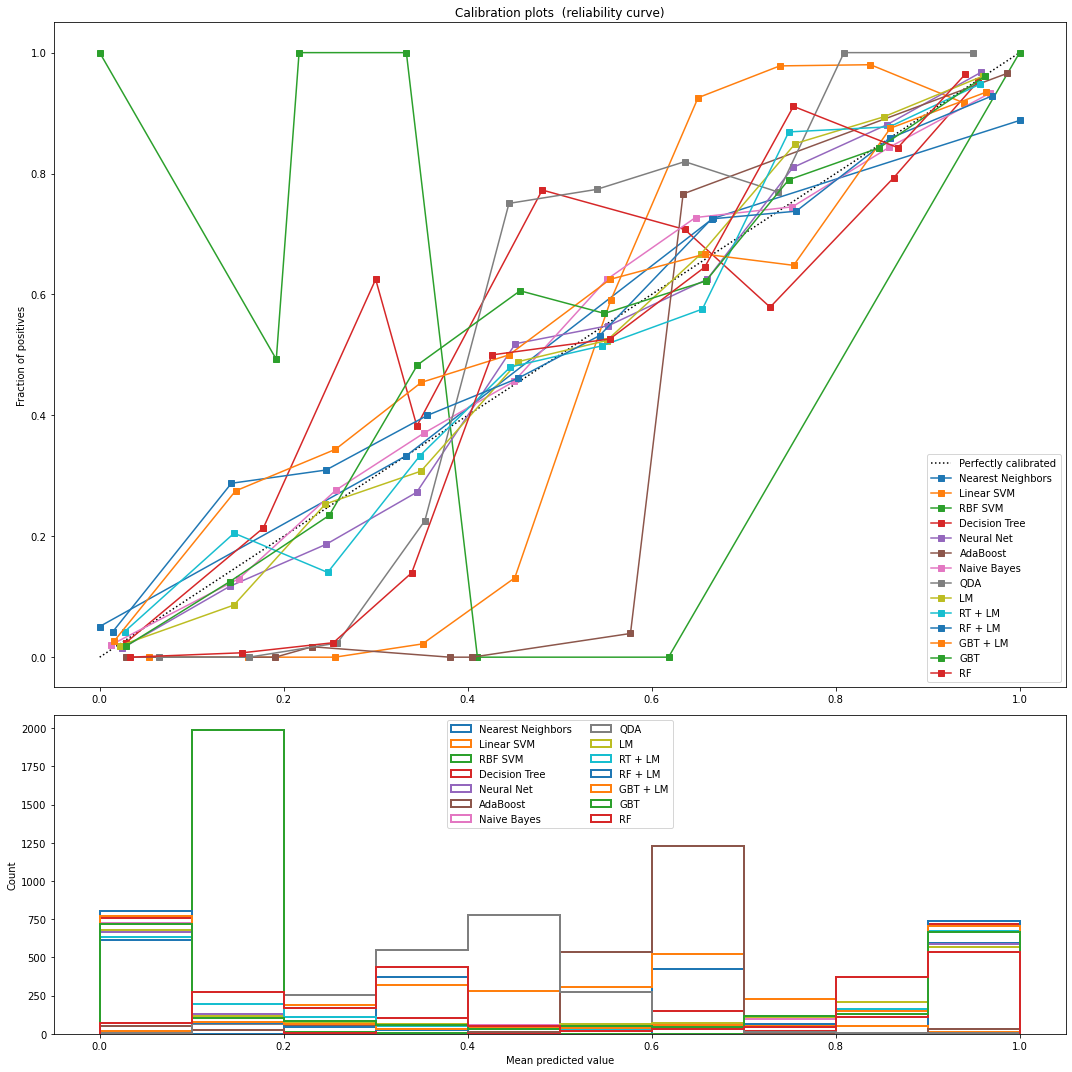

In [6]:
# #############################################################################
# Plot calibration plots
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

plt.figure(figsize=(15, 15))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for prob_pos, name in [[predictEight[n]['prob_pos'],n] for n in names] + [(y_pred_lm,'LM'),
                       (y_pred_rt,'RT + LM'),
                       (y_pred_rf_lm,'RF + LM'),
                       (y_pred_grd_lm,'GBT + LM'),
                       (y_pred_grd,'GBT'),
                       (y_pred_rf,'RF')]:
    
    prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

## 5、14套模型的重要性输出


In [7]:
# 重要性
print('\n -------- RadomFree importances ------------\n')
print(rf.feature_importances_)
print('\n -------- GradientBoosting importances ------------\n')
print(grd.feature_importances_)
print('\n -------- Logistic Coefficient  ------------\n')
print(lm.coef_ )


# 其他几款模型的特征选择
eight_names = list(predictEight.keys())
[[predictEight[n]['importance'],n] for n in eight_names if predictEight[n]['importance'] != [] ]


 -------- RadomFree importances ------------

[0.00296091 0.00342745 0.01563262 0.00604974 0.0034983  0.07484716
 0.00225245 0.00320943 0.00864947 0.00636088 0.00102355 0.07940459
 0.0054721  0.0037093  0.00189582 0.22083259 0.00918668 0.00374317
 0.54725516 0.00058863]

 -------- GradientBoosting importances ------------

[0.00216315 0.00164217 0.00414873 0.00262191 0.00313331 0.00747766
 0.00190969 0.00233502 0.00285445 0.00150632 0.00115527 0.0093479
 0.00351502 0.00191607 0.00113117 0.01832198 0.00253518 0.00121355
 0.92930677 0.00176468]

 -------- Logistic Coefficient  ------------

[[-0.0428897  -0.03642022 -0.04947043  0.13252639  0.02648274 -0.17968183
  -0.00578436 -0.00514013  0.01951968 -0.02658481 -0.06581354 -0.49472675
   0.02783772 -0.09476863 -0.03198238  0.97092936  0.10570689  0.06479152
   2.33430639 -0.05842235]]


<ipython-input-7-a661cabe8053>:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  [[predictEight[n]['importance'],n] for n in eight_names if predictEight[n]['importance'] != [] ]


[[array([[-0.01216941, -0.00803642, -0.0371962 ,  0.0440979 ,  0.02813782,
          -0.11937585, -0.01560251,  0.00472539,  0.00288186, -0.02019184,
          -0.03446023, -0.3192126 ,  0.01783739, -0.03038167, -0.03201148,
           0.5766335 ,  0.0523026 ,  0.0390042 ,  1.41965647, -0.02905152]]),
  'Linear SVM'],
 [array([2.09875561e-03, 0.00000000e+00, 1.25998010e-03, 0.00000000e+00,
         7.28734587e-04, 1.89254296e-02, 1.31368357e-03, 1.01971475e-03,
         3.11957777e-03, 0.00000000e+00, 0.00000000e+00, 1.24014043e-03,
         2.29969029e-03, 0.00000000e+00, 1.06086399e-03, 5.01131094e-03,
         2.01052164e-03, 9.20372735e-04, 9.58991224e-01, 0.00000000e+00]),
  'Decision Tree'],
 [array([0.02, 0.06, 0.08, 0.02, 0.  , 0.04, 0.04, 0.  , 0.02, 0.04, 0.  ,
         0.1 , 0.  , 0.04, 0.  , 0.18, 0.04, 0.02, 0.3 , 0.  ]),
  'AdaBoost'],
 [array([[0.99215286, 1.00848734, 1.06211506, 1.0240741 , 0.98769432,
          0.4869747 , 1.02797477, 1.01967028, 0.95005496, 0.93633662

## 6、14套模型的ROC值计算与plot


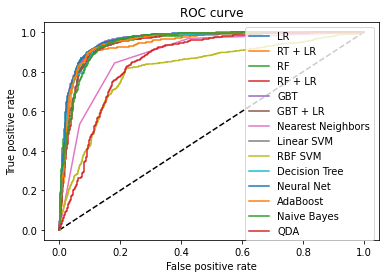

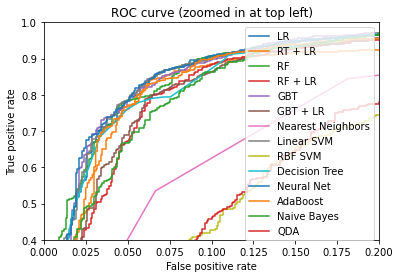

In [8]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lm, tpr_lm, label='LR')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
# 8 款模型
for (fpr,tpr),name in [[predictEight[n]['fpr_tpr'],n] for n in eight_names] :
    plt.plot(fpr, tpr, label=name)
    

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.4, 1)     # ylim改变     # matt
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lm, tpr_lm, label='LR')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
for (fpr,tpr),name in [[predictEight[n]['fpr_tpr'],n] for n in eight_names] :
    plt.plot(fpr, tpr, label=name)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

## optimize

    借助快照集成，参考：(titu1994/Snapshot-Ensembles)[https://github.com/titu1994/Snapshot-Ensembles]


## 7、加权模型融合数据准备


In [9]:
# from MinimiseOptimize import MinimiseOptimize,log_loss_func,calculate_weighted_accuracy

# 集成数据准备
preds_dict = {}
for pred_tmp,name in [[predictEight[n]['prob_pos'],n] for n in names] + [(y_pred_lm,'LM'),
                       (y_pred_rt,'RT + LM'),
                       (y_pred_rf_lm,'RF + LM'),
                       (y_pred_grd_lm,'GBT + LM'),
                       (y_pred_grd,'GBT'),
                       (y_pred_rf,'RF')]:
    preds_dict[name] = np.array([1 - pred_tmp , pred_tmp]).T

# 参数准备
preds = list(preds_dict.values())
models_filenames = list(preds_dict.keys())  # 模型个数
sample_N,nb_classes = preds[0].shape  # 样本数/分类数
testY = y_test.reshape((len(y_test),1))  # 真实Label (2000,1)
testY_cat = np.array([1 - y_test ,y_test]).T # (2000,2)   

## 8、基准优化策略：14套模型融合——平均


In [10]:
# 模型集成：无权重
    # 无权重则代表权重为平均值
    
    
prediction_weights = [1. / len(models_filenames)] * len(models_filenames)
calculate_weighted_accuracy(prediction_weights)

Accuracy :  87.1
Recall :  0.8768920282542886


## 9、加权平均优化策略：14套模型融合——加权平均优化

In [11]:
# 模型集成：附权重
best_acc,best_weights = MinimiseOptimize(preds,models_filenames,nb_classes,sample_N,testY,NUM_TESTS = 20)


 ------- Iteration : 1  - acc: 89.9  - rec:0.9112008072653885 -------  
    Best Ensemble Weights: 
 [9.39305744e-02 8.17490213e-04 7.21274598e-18 2.76659200e-02
 2.01474781e-01 1.09660230e-02 1.47044662e-22 0.00000000e+00
 7.10928002e-02 5.07763599e-22 5.94052411e-01 3.11248461e-17
 4.05696759e-18 8.68332543e-18]

 ------- Iteration : 2  - acc: 90.14999999999999  - rec:0.9112008072653885 -------  
    Best Ensemble Weights: 
 [1.83880000e-06 1.38943213e-03 1.75379768e-02 2.20796683e-01
 7.58154093e-03 8.05158020e-07 2.01998644e-01 5.42057540e-08
 5.03120855e-01 3.53512902e-02 1.83793083e-15 1.22206464e-02
 2.72729909e-18 3.34792188e-07]

 ------- Iteration : 3  - acc: 89.8  - rec:0.9081735620585267 -------  
    Best Ensemble Weights: 
 [1.93249605e-03 2.35154266e-03 1.82989240e-03 2.74282797e-02
 4.93008498e-01 1.01940297e-16 1.51749947e-17 3.68877536e-04
 2.17449203e-01 1.43765021e-17 7.65483666e-02 1.54346619e-01
 2.05674777e-17 2.47362257e-02]

 ------- Iteration : 4  - acc: 90.1

In [12]:
# 附权重的最终结果展示
print("Best Accuracy : ", best_acc)
print("Best Weights : ", best_weights)
calculate_weighted_accuracy(best_weights)

Best Accuracy :  90.4
Best Weights :  [5.83558955e-02 0.00000000e+00 6.83832970e-08 3.42688873e-01
 2.54579475e-15 1.05072861e-02 1.39125275e-15 6.61282315e-04
 2.77075552e-01 6.14875080e-16 1.56667449e-13 4.42179074e-15
 3.10711043e-01 7.70735231e-15]
Accuracy :  90.4
Recall :  0.9122098890010091
